In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import struct
from mmap import ACCESS_READ, mmap

In [608]:
class SpecReader:
    """TODO."""
    def __init__(self, spec_file):
        """TODO."""
        self.input_file = spec_file
        self.output_file = spec_file + ".hr"
        self.made_hr = True
        self.bpos = 0
        try:
            f = open(self.output_file, 'r')
            f.close()
        except:
            self.made_hr = False
        
        
    def write(self, data_array, fout):
        """TODO."""
        fout.write(str(data_array[0]))
        if len(data_array) > 1:
            for datum in data_array[1:]:
                fout.write(" " + str(datum))
        fout.write("\n")
            

    def read(self, fmt, buffer):
        """TODO"""
        old_bpos = self.bpos
        self.bpos += struct.calcsize(fmt)
        retval = struct.unpack(fmt, buffer[old_bpos:self.bpos])
        if len(retval) == 1:
            return retval[0]
        else:
            return retval


    def make_human_readable(self):
        """TODO."""

        with open(self.input_file, 'rb', 0) as f, mmap(f.fileno(), 0, access=ACCESS_READ) as s, open(self.output_file, 'w+') as fout:

            header = self.read('iid', s)
            self.write(["n_steps", "n_spec", "delta", "n_filaments", "diameter", 
                        "length", "bond_length", "persistence_length", "n_sites"], fout)

            n_samples = header[0]//header[1]
            num = self.read('i', s)
            details = self.read('ddd', s)
            n_sites = self.read("i", s)
            posits = list(self.read('ddd'*n_sites, s))
            perlen = self.read('d', s)
            self.bpos += struct.calcsize('c')
            self.write(list(header) + [num] + list(details) + [perlen, n_sites], fout)
            self.write(["site_positions_x_y_z"], fout)
            for fil in range(1, num):
                self.bpos += struct.calcsize('dddi')
                posits += list(self.read("ddd"*n_sites, s))
                self.bpos += struct.calcsize('dc')
            self.write(posits, fout)
            for sample in range(1, n_samples):
                self.bpos += struct.calcsize('i')
                posits = []
                for fil in range(num):
                    self.bpos += struct.calcsize('dddi')
                    posits += list(self.read("ddd"*n_sites, s))
                    self.bpos += struct.calcsize('dc')
                self.write(posits, fout)
        self.made_hr = True
        self.bpos = 0

#struct
    def get_params_specs(self):
        """TODO."""
        if (self.made_hr):
            params = pd.read_csv(self.output_file, delim_whitespace=True, nrows=1)
            specs = pd.read_csv(self.output_file, skiprows=3, delim_whitespace=True, header=None, )
            n_sites = params.n_sites[0]
            n_fils = params.n_filaments[0]
            fil_labels = [i for sub in [['fil{:03d}'.format(i)]*3*n_sites for i in range(n_fils)] for i in sub]
            site_labels = [i for sub in [['site{:03d}'.format(i)]*3 for i in range(n_sites)]*n_fils for i in sub]
            arrays = [fil_labels, site_labels, ['x', 'y', 'z']*n_sites*n_fils]
            columns = pd.MultiIndex.from_arrays(arrays, names=['filament', 'site', 'coord'])
            specs.columns = columns
            specs.index.name = 'time'
            return params, specs
        else:
            print("Error: SpecReader has not yet made human-readable file")
            raise Exception
            return None, None

In [523]:
sreader = SpecReader('filament_undulation_flex_v004_filament_generic.spec')

In [524]:
sreader.make_human_readable();

In [444]:
params, specs = sreader.get_params_specs()
specs = specs[1:]

Error: SpecReader has not yet made human-readable file


ValueError: could not broadcast input array from shape (4999,0) into shape (4999,3)

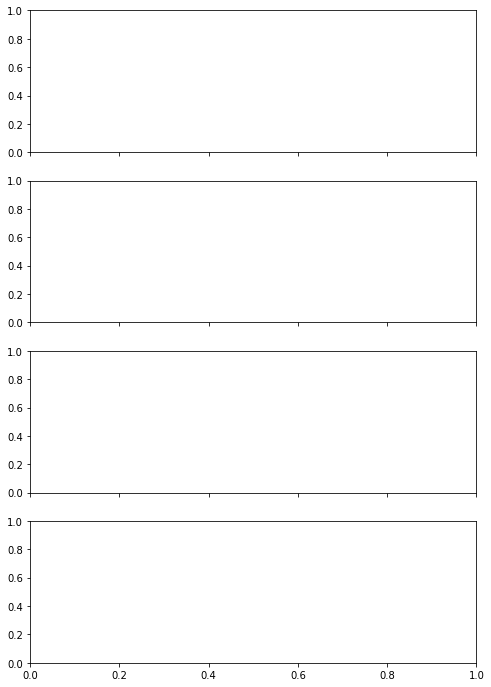

In [926]:
def atan2(x):
    return np.arctan2(x[1], x[0])

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 12))
for ax, file, fdr in zip(axes, ['filament_undulation_stiff_v{:03d}_filament_generic.spec'.format(i) for i in range(0,9,3)], [0, 0.3, 3, 30]):
    sreader = SpecReader(file)
    try:
        params, specs = sreader.get_params_specs()
    except:
        sreader.make_human_readable()
        params, specs = sreader.get_params_specs()
    specs = specs[1:]
    num = params.n_filaments[0]
    n_samples = params.n_steps[0]//params.n_spec[0] - 1
    u_vecs = np.zeros((n_samples, num*3))
    angles = np.zeros((n_samples, num))
    inc = 27*3
    for i in range(num):
        k = specs.iloc[:, i*inc+24:i*inc+27].values - specs.iloc[:, i*inc+21:i*inc+24].values
        norms = np.apply_along_axis(np.linalg.norm, 1, k)
        k /= norms[:, None]
        u_vecs[:, 3*i:3*i+3] = k
        angles[:, i:i+1] = np.arcsin(k[:,0])[:, None] #np.apply_along_axis(atan2, 1, k)[:, None]
    ax.hist((np.diff(angles, n=1, axis=0)).flatten(), bins=np.linspace(-0.3, 0.3, 50), label=fdr, density=True)
    #ax.hist(angles.flatten(), bins=50, label=fdr)
    ax.legend(loc='best')
    ax.set_xlim(-0.3,0.3)
    fig.tight_layout()
    fig.suptitle('Lp = {}'.format(int(params.persistence_length[0])))
    fig.savefig('undulation_lp{:03d}.png'.format(int(params.persistence_length[0])))

In [436]:
angles.max()

1.5653316989571122

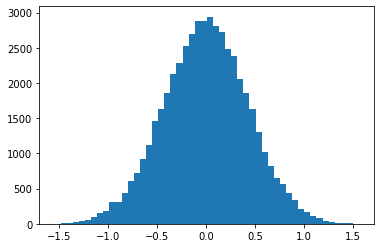

In [437]:
plt.figure()
plt.hist(angles.flatten(), bins=50)
plt.show()

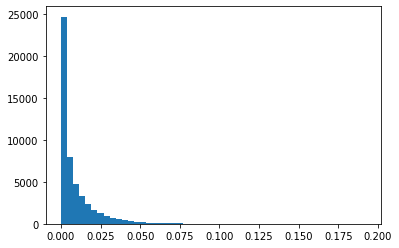

In [438]:
plt.figure()
plt.hist((np.diff(angles, n=1, axis=0)**2).flatten(), bins=50)
plt.show()

In [944]:
def plotEnergies(fnames):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for fname, fdr in zip(fnames, [0, 0.1, 1, 10]):
        sreader = SpecReader(fname)
        sreader.make_human_readable()
        try:
            params, specs = sreader.get_params_specs()
        except:
            #sreader.make_human_readable()
            params, specs = sreader.get_params_specs()
        specs = specs[1:]
        site_positions=specs.stack(level=[0, 2]).transpose()
        bond_diffs = site_positions.diff().dropna().diff().dropna()
        bond_diffs.iloc[:, :] = bond_diffs.values**2
        angles = bond_diffs.transpose().unstack(level=[0,1]).sum(axis=0)
        angles = angles.unstack(level=[0, 2]).swaplevel(axis=1).sort_index(axis=1, level=0)
        energies = angles.stack(level=[0]).sum(axis=1)
        ax.hist(energies.unstack().values.flatten(), bins=50, label=r'$f_{dr} = $'+ '{}'.format(fdr), density=True, alpha=0.6)
    ax.legend(loc='best', fontsize=18)
    ax.set_xlabel("Bending Energy", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    fig.savefig("bending_energy_lp{:03d}_dr10.png".format(int(params.persistence_length[0]/params.length[0])))
    plt.show()

In [941]:
fnames

['undulation_exam_v000_filament_generic.spec',
 'undulation_exam_v001_filament_generic.spec',
 'undulation_exam_v002_filament_generic.spec',
 'undulation_exam_v003_filament_generic.spec']

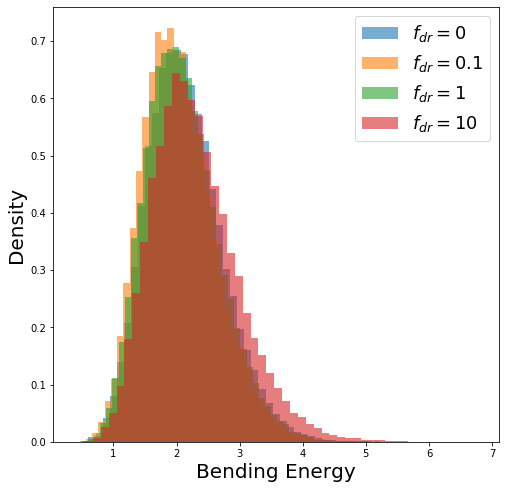

In [946]:
fnames = ['undulation_exam_v{:03d}_filament_generic.spec'.format(i) for i in range(0, 4)]
plotEnergies(fnames)